# QTL/gene functional enrichment
- GREAT, GO terms, etc.
- torus

In [1]:
suppressMessages(library(data.table))
suppressMessages(library(dplyr))
suppressMessages(library(ggplot2))
library(ggforestplot)
library("ggsci")

## GREAT

In [21]:
suppressMessages(library(rGREAT))

In [22]:
egene <- fread("~/project-gandalm/isoform_twas/eqtl_new/results/mixed_perm_90hcp/sig_pheno.txt", data.table = F, header = T)
head(egene)

,pid,nvar,shape1,shape2,dummy,sid,dist,npval,slope,ppval,bpval,qval,pval_nominal_threshold
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENSG00000000419,6979,1.02134,1367.680,476.819,rs192563417,785096,1.36171e-07,-0.505097,0.00079992,6.71442e-04,1.47123e-03,2.90212e-05
2,ENSG00000000460,7370,1.03366,743.049,467.386,rs17529513,167500,1.08049e-22,-0.302487,0.00009999,6.83032e-18,5.86726e-17,5.58582e-05
3,ENSG00000001036,5683,1.04787,948.786,469.456,rs4896658,-47658,1.77472e-07,-0.588128,0.00069993,5.90912e-04,1.30931e-03,4.60076e-05
4,ENSG00000001460,5648,1.04183,862.516,466.170,rs760969,2280,1.34110e-62,-0.657378,0.00009999,1.67187e-54,8.74000e-53,4.95438e-05
5,ENSG00000001461,5648,1.04028,804.007,459.959,rs497071,-28459,3.82613e-21,-0.304292,0.00009999,2.93508e-16,2.26687e-15,5.28578e-05
6,ENSG00000001561,5517,1.03939,749.126,465.199,rs34269469,20326,1.39239e-12,0.129466,0.00009999,1.17992e-08,4.79713e-08,5.65509e-05


In [23]:
coord <- fread("~/project-gandalm/isoform_twas/salmon/gencode.gene.noVersion.tsv", data.table = F, header = F)
head(coord)

,V1,V2,V3,V4,V5
,<chr>,<int>,<int>,<chr>,<chr>
1,chr1,11869,14409,+,ENSG00000223972
2,chr1,14404,29570,-,ENSG00000227232
3,chr1,29554,31109,+,ENSG00000243485
4,chr1,34554,36081,-,ENSG00000237613
5,chr1,52473,53312,+,ENSG00000268020
6,chr1,57598,64116,+,ENSG00000240361


In [24]:
egene <- egene %>% select(pid) %>% left_join(coord, by=c('pid'='V5'))
head(egene)

,pid,V1,V2,V3,V4
,<chr>,<chr>,<int>,<int>,<chr>
1,ENSG00000000419,chr20,49551404,49575092,-
2,ENSG00000000460,chr1,169631245,169823221,+
3,ENSG00000001036,chr6,143815949,143832857,-
4,ENSG00000001460,chr1,24683489,24743424,-
5,ENSG00000001461,chr1,24742292,24799466,+
6,ENSG00000001561,chr6,46097726,46114425,+


In [25]:
egene <- egene %>% select(V1, V2, V3)
head(egene)

,V1,V2,V3
,<chr>,<int>,<int>
1,chr20,49551404,49575092
2,chr1,169631245,169823221
3,chr6,143815949,143832857
4,chr1,24683489,24743424
5,chr1,24742292,24799466
6,chr6,46097726,46114425


In [26]:
# submit to GREAT
job <- submitGreatJob(egene, species = "hg19") 
tb <- getEnrichmentTables(job)

Don't make too frequent requests. The time break is 300s.
Please wait for 193s for the next request.
The time break can be set by `request_interval` argument.




  |======================================================================| 100%


Warning message in submitGreatJob(egene, species = "hg19"):
“GREAT gives a warning:
Your set hits a large fraction of the genes in the genome, which often
does not work well with the GREAT Significant by Both view due to a
saturation of the gene-based hypergeometric test.

See our tips for handling large datasets or try the Significant By
Region-based Binomial view.”


In [27]:
names(tb)
job
availableOntologies(job)
availableCategories(job)

[1] "GO Molecular Function" "GO Biological Process" "GO Cellular Component"

Submit time: 2021-08-24 13:51:13 
Version: 4.0.4 
Species: hg19 
Inputs: 10094 regions
Background: wholeGenome 
Model: Basal plus extension 
  Proximal: 5 kb upstream, 1 kb downstream,
  plus Distal: up to 1000 kb
Include curated regulatory domains

Enrichment tables for following ontologies have been downloaded:
  GO Biological Process
  GO Cellular Component
  GO Molecular Function


[1] "GO Molecular Function"     "GO Biological Process"    
[3] "GO Cellular Component"     "Mouse Phenotype"          
[5] "Mouse Phenotype Single KO" "Human Phenotype"          
[7] "Ensembl Genes"

[1] "GO"        "Phenotype" "Genes"

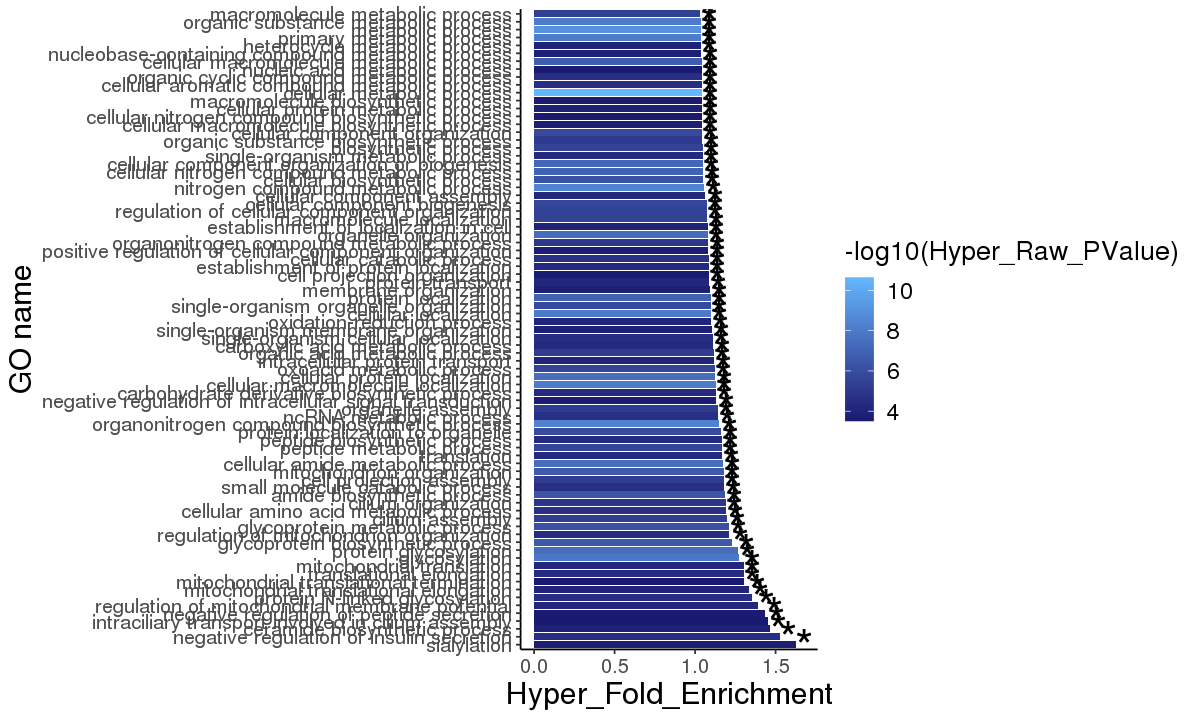

In [30]:
# GO Molecular Function
dat_mf <- tb[["GO Biological Process"]] %>% filter(Hyper_Adjp_BH < 0.05)
label_df <- data.frame(name = dat_mf$name,
                       Hyper_Fold_Enrichment = dat_mf$Hyper_Fold_Enrichment+.05)
# TODO: which variables to use/plot?
options(repr.plot.height = 6, repr.plot.width = 10)
p <- ggplot(dat_mf, aes(y = Hyper_Fold_Enrichment, x = reorder(name, -Hyper_Fold_Enrichment))) +
  geom_bar(stat = "identity", aes(fill = -log10(Hyper_Raw_PValue))) +
  coord_flip() +
  theme_classic() +
  scale_fill_gradient(low = "midnightblue", high = "steelblue1", name = "-log10(Hyper_Raw_PValue)") +
  geom_text(data = label_df, label = "*", color = "black", size = 10, nudge_x = -.2) +
  theme(axis.text = element_text(size = 12),
        axis.title = element_text(size = 18),
        legend.title = element_text(size = 16),
        legend.text = element_text(size = 14)) +
  labs(x = "GO name")
p

## torus

In [2]:
eqtl <- read.table("~/project-gandalm/isoform_twas/eqtl_new/results/mixed_nominal_90hcp/torus.out", header = F, stringsAsFactors = F)
isoqtl <- read.table("~/project-gandalm/isoform_twas/isoqtl_new/results/mixed_nominal_70hcp/torus.out", header = F, stringsAsFactors = F)
sqtl <- read.table("~/project-gandalm/isoform_twas/sqtl_new/results/mixed_nominal_40hcp_1e6/torus.out", header = F, stringsAsFactors = F)

In [3]:
eqtl <- eqtl[2:18,]
colnames(eqtl) <- c("annot", "log_or", "int1", "int2")
eqtl$annot <- gsub(".1","",eqtl$annot)
eqtl$group <- "eQTL"
isoqtl <- isoqtl[2:18,]
colnames(isoqtl) <- c("annot", "log_or", "int1", "int2")
isoqtl$annot <- gsub(".1","",isoqtl$annot)
isoqtl$group <- "isoQTL"
sqtl <- sqtl[2:18,]
colnames(sqtl) <- c("annot", "log_or", "int1", "int2")
sqtl$annot <- gsub(".1","",sqtl$annot)
sqtl$group <- "sQTL"

In [4]:
df <- rbind(eqtl, isoqtl, sqtl)
df$annot <- gsub('_', ' ', df$annot)

In [5]:
df$annot <- gsub('promoter flanking region', 'promoter-flanking', df$annot)
df$annot <- gsub('open chromatin region', 'open chromatin', df$annot)
df$annot <- gsub('5 prime UTR variant', "5'UTR", df$annot)
df$annot <- gsub('3 prime UTR variant', "3'UTR", df$annot)
df$annot <- gsub('frameshift variant', 'frameshift', df$annot)
df$annot <- gsub('intron variant', 'intron', df$annot)
df$annot <- gsub('missense variant', 'missense', df$annot)
df$annot <- gsub('non coding transcript exon variant', 'non-coding transcript', df$annot)
df$annot <- gsub('splice acceptor variant', 'splice acceptor', df$annot)
df$annot <- gsub('splice donor variant', 'splice donor', df$annot)
df$annot <- gsub('splice region variant', 'splice region', df$annot)
df$annot <- gsub('synonymous variant', 'synonymous', df$annot)

In [6]:
df$annot <- factor(df$annot, levels = rev(c('enhancer', 'promoter', 'open chromatin', 'promoter-flanking',
                                       'CTCF binding site', 'TF binding site', "3'UTR", "5'UTR",
                                       'frameshift', 'intron', 'missense', 'non-coding transcript', 'splice acceptor',
                                       'splice donor', 'splice region', 'stop gained', 'synonymous')))

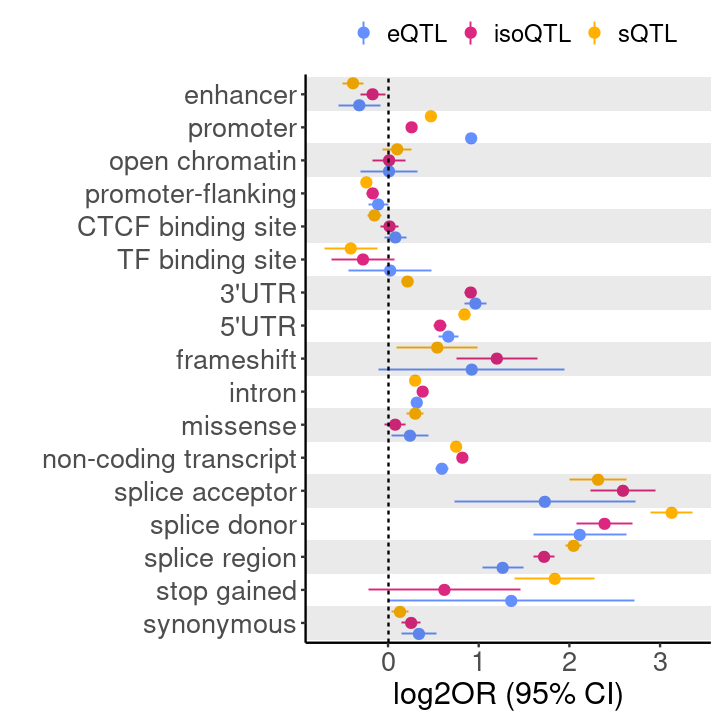

In [7]:
options(repr.plot.height = 6, repr.plot.width = 6)

# colors <- c("eQTL" = "#6699FF", "isoQTL" = "#CC33FF", "sQTL" = "#00FF00")
colors <- c("eQTL" = "#648FFF", "isoQTL" = "#DC267F", "sQTL" = "#FFB000")
# colors <- c("eQTL" = "#6699FF", "isoQTL" = "#FF00CCFF", "sQTL" = "#79CC3DFF")

# x_labs <- c('-0.25', '0', '0.25', '0.5', '')
# x_ticks <- c(-0.25, 0, 0.25, 0.5, 0.75)

ggplot(df, aes(y = annot, x = log_or)) +
#     coord_flip() +
#     geom_point(aes(color = group), size = 4, position=position_dodge(width=0.3)) +
    geom_pointrange(aes(xmin = int1, xmax = int2, color = group), 
                    size = .4, position = position_dodge(width = 1), alpha = 1) +
    scale_color_manual(values = colors) +
#     scale_color_d3() +
    theme_classic() +
    theme(axis.text = element_text(size = 16),
          axis.title = element_text(size = 18),
          legend.text = element_text(size = 14),
          legend.title = element_blank(),
          legend.position = "top") +
    labs(x = "log2OR (95% CI)", y = "") +
    geom_stripes(odd = "#16161616", even = "#00000000") +
    geom_vline(xintercept = 0, linetype = "dashed")  
#     scale_x_continuous(labels = x_labs, breaks = x_ticks)

In [8]:
ggsave("../figures/func_enrich.pdf", width = 6, height = 6)